### Harmonization and annotation of data collections with scVI and scANVI
An important task of single-cell analysis is the integration of several datasets. scVI can be used for this purpose. We also introduce scANVI, an end-to-end framework for transfer of annotations. We also show how to use these frameworks for differential gene expression analysis. Here we demonstrate this functionality with an integrated analysis of two datasets of peripheral blood mononuclear cells publicly available from 10X Genomics. The same pipeline would generally be used to analyze a collection of scRNA-seq datasets.

If running in Colab, navigate to Runtime -> Change runtime type and ensure you're using a Python 3 runtime with GPU hardware accelerator installation in Colab can take several minutes.


In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

def allow_notebook_for_test():
    print("Testing the harmonization notebook")

show_plot = True
test_mode = False
save_path = "data/"

if IN_COLAB:
    !pip install --quiet git+https://github.com/yoseflab/scvi@dev_v1.0#egg=scvi[notebooks]
else:
    %load_ext nb_black


     |████████████████████████████████| 112kB 8.9MB/s 
     |████████████████████████████████| 122kB 8.6MB/s 
     |████████████████████████████████| 8.7MB 13.8MB/s 
     |████████████████████████████████| 4.3MB 59.5MB/s 
     |████████████████████████████████| 153kB 63.2MB/s 
     |████████████████████████████████| 2.2MB 58.3MB/s 
     |████████████████████████████████| 2.4MB 54.6MB/s 
     |████████████████████████████████| 3.2MB 60.4MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 7.7MB 50.5MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 921kB 58.8MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc

import scvi

%matplotlib inline

# Use GPU
use_cuda = True

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


For this manuscript, we focus on the use case presented in the data harmonization tutorial by [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/integrating-data-using-ingest.html) 

This dataset has around fifteen thousands peripheral blood mononuclear cells with two experimental assays (3' and 5').

In [ ]:
dataset1 = sc.read(
    "data/TM_droplet.h5ad",
    backup_url="https://s3.amazonaws.com/czbiohub-tabula-muris/TM_droplet_mat.h5ad",
)

In [ ]:
dataset2 = sc.read(
    "data/TM_facs.h5ad",
    backup_url="https://s3.amazonaws.com/czbiohub-tabula-muris/TM_facs_mat.h5ad",
)

In [ ]:
dataset1.obs = pd.read_csv(
    "https://github.com/czbiohub/tabula-muris-vignettes/raw/master/data/TM_droplet_metadata.csv"
)
dataset2.obs = pd.read_csv(
    "https://github.com/czbiohub/tabula-muris-vignettes/raw/master/data/TM_facs_metadata.csv",
)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Subset to marrow

In [ ]:
dataset1 = dataset1[dataset1.obs.tissue == "Marrow"].copy()
dataset2 = dataset2[dataset2.obs.tissue == "Marrow"].copy()

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### normalize Smartseq2 matrix by gene length
This is because the number of reads representing a transcript is proportional to the lenght of the transcript, unless UMI is used. A discussion of this phenomenon can be found in this 2017 [paper](https://europepmc.org/article/med/28529717) by Phipson B. 
Other than the gene length normalization, no other normalization is needed. scVI or scANVI is designed to handle sequencing depth and does not need cell-wise normalization. Normalizing and scaling the data will be detrimental to the performance of scVI and scANVI since they model explicitly the count data. 

In [ ]:
gene_len = pd.read_csv(
    "https://raw.githubusercontent.com/chenlingantelope/HarmonizationSCANVI/master/data/gene_len.txt",
    delimiter=" ",
    header=None,
    index_col=0,
)
gene_len.head()

,1
0,
0610007C21Rik,94.571429
0610007L01Rik,156.000000
0610007P08Rik,202.272727
0610007P14Rik,104.000000
0610007P22Rik,158.750000


In [ ]:
gene_len = gene_len.reindex(dataset2.var.index).dropna()
dataset2 = dataset2[:, gene_len.index]
assert (dataset2.var.index == gene_len.index).sum() == dataset2.shape[1]
dataset2.X = (dataset2.X / gene_len[1].values * np.median(gene_len[1].values))
# round to integer
dataset2.X = np.rint(dataset2.X)

### Gene selection
Another important thing to keep in mind is highly-variable gene selection. While scVI and scANVI both accomodate for large gene sets in terms of runtime, we usually recommend filtering genes for best performance when the dataset has few number of cells. As a rule of thumb, performance starts to decrease when number of cells and number of genes are comparable. This point is emphasized in this [comparative analysis](https://doi.org/10.1101/2020.05.22.111161) of data integration algorithms for scRNA-seq data.

We perform this gene selection using the scanpy pipeline while keeping the raw data in the adata.raw object. We obtain variable genes from each dataset and take their intersections. 


First, we concatenate the datasets

In [ ]:
adata = dataset1.concatenate(dataset2)

In [ ]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata, 
    flavor="seurat_v3", 
    n_top_genes=2000, 
    layer="counts", 
    batch_key="batch"
)
adata.raw = adata # keep full dimension safe
adata = adata[:, adata.var.highly_variable].copy()

### Harmonization with scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:
+ register the AnnData object with the correct key to identify the sample,
+ create a SCVI object and connect it to the AnnData.

In [ ]:
scvi.dataset.setup_anndata(adata, batch_key="batch", layer="counts")

INFO      Using batches from adata.obs["batch"]                                 
INFO      No label_key inputted, assuming all cells have same label             
INFO      Using data from adata.layers["counts"]                                
INFO      Computing library size prior per batch                                
INFO      Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 
          'labels']                                                             
INFO      Successfully registered anndata object containing 9467 cells, 2000    
          genes, 2 batches, 1 labels, and 0 proteins. Also registered 0 extra   
          categorical covariates and 0 extra continuous covariates.             


In [ ]:
vae = scvi.models.SCVI(adata, use_cuda=True)

Now we train scVI by calling vae.train(). This should take a couple of minutes on a Colab session

In [ ]:
vae.train()

INFO      KL warmup for 400 epochs                                              
training: 100%|██████████| 400/400 [05:05<00:00,  1.31it/s]


Once the training is done, we can evaluate the latent representation of each cell in the dataset and add it to the AnnData object

In [ ]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

Finally, we can cluster the dataset and visualize it with UMAP

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)

... storing 'channel' as categorical
... storing 'mouse.id' as categorical
... storing 'tissue' as categorical
... storing 'subtissue' as categorical
... storing 'mouse.sex' as categorical
... storing 'method' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'plate.barcode' as categorical
... storing 'FACS.selection' as categorical


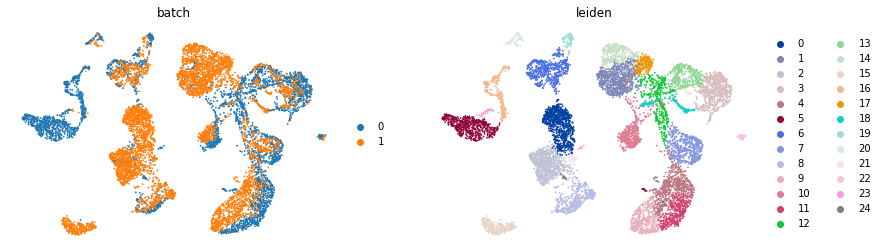

In [ ]:
sc.pl.umap(adata, color=["batch", "leiden"], frameon=False)

Because this combination of datasets is used for benchmarking purposes, we have access here to curated annotations. We can use those to assess whether the harmonization worked reasonably well. 

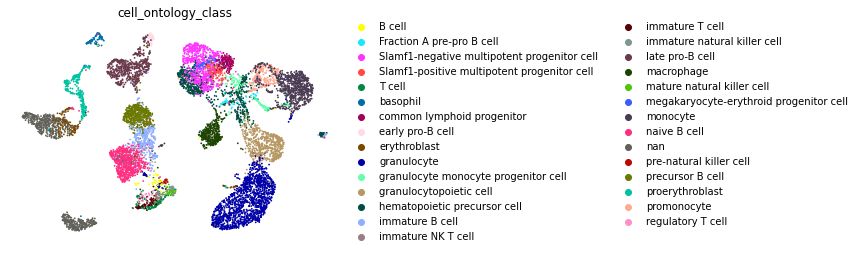

In [ ]:
sc.pl.umap(adata, color=["cell_ontology_class"], frameon=False)

From a quick glance, it looks like the harmonization worked well. Indeed, the two datasets are relatively mixed in latent space and the cell type are preserved. A more refined analysis may be done at the level of markers, we refer to the BBKNN notebook for further details

### Transfer of Annotations with scANVI

We now investigate a different although complementary problem. Previously, we used scVI as we assumed we did not have any cell type annotation available to guide us. Consequently, one would need to use marker genes in order to annotate the clusters from the previous analysis. 

Now, we assume that one dataset plays the role of the reference data, with known labels, and one is the query. We will use scANVI to transfer our cell type knowledge from the reference to the query data. For this, we simply need to indicate to indicate to scANVI:
+ the sample identifier for each cell (as in scVI)
+ the cell type, or an unnassigned label for each cell

We quickly simulate some missing cell type annotation by adding an altered scanpy obs entry with "unknown" cell types for the 5' data

subsample the labels so that each cell type is equally represented

In [ ]:
np.max([len(x) for x in adata.obs.cell_ontology_class.unique()])

43

In [ ]:
labels = np.repeat("Unknown", adata.shape[0])
labels = labels.astype("<U43")
for x in np.unique(adata.obs.cell_ontology_class):
    idx = np.where((adata.obs.cell_ontology_class == x) & (adata.obs["batch"] == "1"))[
        0
    ]
    sampled = np.random.choice(idx, np.min([100, len(idx)]))
    labels[sampled] = adata.obs.cell_ontology_class[sampled]

adata.obs["celltype_scanvi"] = labels

In [ ]:
np.unique(adata.obs["celltype_scanvi"])

array(['B cell', 'Slamf1-negative multipotent progenitor cell',
       'Slamf1-positive multipotent progenitor cell', 'Unknown',
       'basophil', 'common lymphoid progenitor', 'granulocyte',
       'granulocyte monocyte progenitor cell', 'granulocytopoietic cell',
       'hematopoietic precursor cell', 'immature B cell',
       'immature NK T cell', 'immature T cell',
       'immature natural killer cell', 'late pro-B cell', 'macrophage',
       'mature natural killer cell',
       'megakaryocyte-erythroid progenitor cell', 'monocyte',
       'naive B cell', 'nan', 'pre-natural killer cell',
       'precursor B cell', 'regulatory T cell'], dtype=object)

Now we may register the AnnData object and run scANVI

In [ ]:
scvi.dataset.setup_anndata(
    adata, 
    batch_key="batch", 
    labels_key="celltype_scanvi",
    layer="counts"
)

INFO      Using batches from adata.obs["batch"]                                 
INFO      Using labels from adata.obs["celltype_scanvi"]                        
INFO      Using data from adata.layers["counts"]                                
INFO      Computing library size prior per batch                                
INFO      Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 
          'labels']                                                             
INFO      Successfully registered anndata object containing 9467 cells, 2000    
          genes, 2 batches, 24 labels, and 0 proteins. Also registered 0 extra  
          categorical covariates and 0 extra continuous covariates.             


In [ ]:
lvae = scvi.models.SCANVI(
    adata, 
    "Unknown", 
    use_cuda=True, 
    n_latent=30, 
    n_layers=2
)

In [ ]:
lvae.train(n_epochs_semisupervised=100)

INFO      KL warmup for 400 epochs                                              
training: 100%|██████████| 400/400 [06:06<00:00,  1.09it/s]
INFO      KL warmup phase exceeds overall training phaseIf your applications    
          rely on the posterior quality, consider training for more epochs or   
          reducing the kl warmup.                                               
INFO      KL warmup for 400 epochs                                              
training: 100%|██████████| 100/100 [03:50<00:00,  2.31s/it]
INFO      Training is still in warming up phase. If your applications rely on   
          the posterior quality, consider training for more epochs or reducing  
          the kl warmup.                                                        


Now we can predict the missing cell types, and get the latent space

In [ ]:
adata.obs["C_scANVI"] = lvae.predict(adata)
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

Again, we may visualize the latent space as well as the inferred labels

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

... storing 'celltype_scanvi' as categorical
... storing 'C_scANVI' as categorical


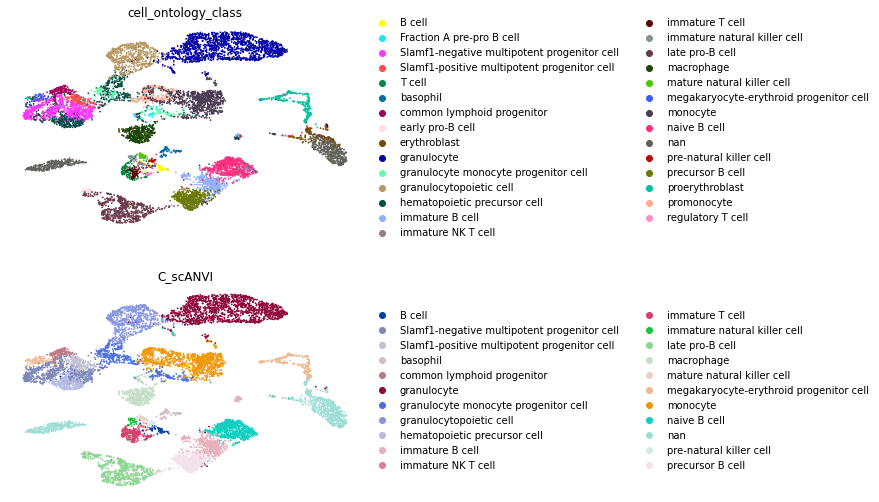

In [ ]:
sc.pl.umap(adata, color=["cell_ontology_class", "C_scANVI"], ncols=1, frameon=False)

As we see in this, scANVI's latent space separates all cell types and performs well at classifying major cell types. It seems to struggle with the identification of Megakaryocytes, which is of low abundance. To mitigate this known effect, it is possible to perform manual curation of the transfered labels for those rare cell types. We also expect some ad-hoc strategies, such as subsampling the amount of labelled cells to be equally balanced among cell types or hyperparameter optimization, to improve these results. 

Ready to learn more? Dig into our [documentation](https://scvi.readthedocs.io/en/stable/)!